In [ ]:
import os
import logging
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from glob import glob
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from lenstools import ConvergenceMap
from lenstools.image.noise import GaussianNoiseGenerator

from src.utils.ConfigData import ConfigData, ConfigAnalysis, CatalogHandler
from src.flatsky.fibonacci_patch import patch_handler

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [ ]:
HUBBLE_CONSTANT = 0.6774
OMEGA_MATTER = 0.3090
cosmo = FlatLambdaCDM(H0=HUBBLE_CONSTANT*100, Om0=OMEGA_MATTER)

nside = 8192
npix = hp.nside2npix(nside)
patch_size = 10
xsize=2048
reso = patch_size*60/xsize
nbin= 15
lmin, lmax = 300, 3000

bins = np.linspace(-4, 4, nbin+1, endpoint=True)
l_edges = np.linspace(lmin, lmax, nbin+1, endpoint=True)

ell = (l_edges[1:] + l_edges[:-1]) / 2
nu = (bins[1:] + bins[:-1]) / 2

In [ ]:
lmin_size = np.pi / np.deg2rad(patch_size)
lmax_size = np.pi / np.deg2rad(reso / 60)

In [ ]:
config_file = os.path.join("/lustre/work/akira.tokiwa/Projects/LensingSSC/configs", 'config_data.json')
config_data = ConfigData.from_json(config_file)

config_analysis_file = os.path.join("/lustre/work/akira.tokiwa/Projects/LensingSSC/configs", 'config_analysis.json')
config_analysis = ConfigAnalysis.from_json(config_analysis_file)

In [ ]:
dir_results_tiled = os.path.join(config_analysis.resultsdir, 'tiled')
dir_results_bigbox = os.path.join(config_analysis.resultsdir, 'bigbox')

# Settings

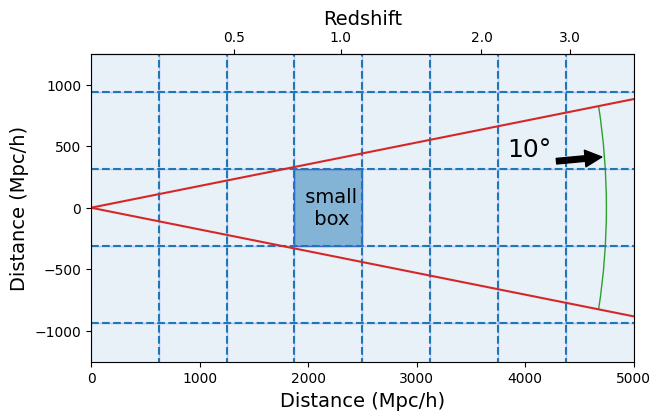

In [ ]:
from matplotlib.patches import Arc
save_dir = '/lustre/work/akira.tokiwa/Projects/LensingSSC/img/setting'

# Parameters
box_length = 5000  # Mpc/h
replications = 8
opening_angle_deg = patch_size

# Calculate total length in the line of sight
total_length = 625 * replications  # Mpc/h

# Convert opening angle to radians
opening_angle_rad = np.deg2rad(opening_angle_deg)

# Calculate the extent of the light cone in x and y directions
extent = total_length * np.tan(opening_angle_rad)

# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 4))

# Draw the replicated boxes
for i in range(replications):
    ax.vlines(x=i * 625, ymin=-box_length / 2, ymax=box_length / 2, color='tab:blue', linestyle='--')

for i in range(4):
    ax.hlines(y=(i+0.5) * 625, xmin=0, xmax=box_length, color='tab:blue', linestyle='--')
    ax.hlines(y=-(i+0.5) * 625, xmin=0, xmax=box_length, color='tab:blue', linestyle='--')

for i in range(replications):
    for j in range(4):
        rect = plt.Rectangle((i * 625, -625/2 + j * 625), 625, 625, edgecolor='blue', linestyle='-', fill=True, alpha=0.1)
        ax.add_patch(rect)
        if j != 0:
            rect = plt.Rectangle((i * 625, -625/2 - j * 625), 625, 625, edgecolor='blue', linestyle='-', fill=True, alpha=0.1)
            ax.add_patch(rect)

rect = plt.Rectangle((3 * 625, -625/2), 625, 625, edgecolor='blue', linestyle='-', fill=True, alpha=0.5)
ax.add_patch(rect)
ax.text(3 * 625 + 625/2, 0, ' small\n box', fontsize=14, color='black', ha='center', va='center')
    
# Draw the light cone
x_coords = [0, total_length]
y_coords = [0, extent]
ax.plot(x_coords, y_coords, color='tab:red')

x_coords = [0, total_length]
y_coords = [0, -extent]
ax.plot(x_coords, y_coords, color='tab:red')

# Add the opening angle arc
arc = Arc((0, 0), width=total_length*1.9, height=1.9*total_length, angle=0,
          theta1=-opening_angle_deg, theta2=opening_angle_deg, color='tab:green')
ax.add_patch(arc)

# Add the opening angle annotation
arc_radius = total_length*0.95
arc_x = arc_radius * np.cos(opening_angle_rad / 2)
arc_y = arc_radius * np.sin(opening_angle_rad / 2)
ax.annotate(f'{opening_angle_deg}°',
            xy=(arc_x, arc_y),
            xytext=(arc_x - 900, arc_y - 0),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=18,
            color='black')

# Set limits and labels
ax.set_xlim(0, total_length)
ax.set_ylim(-box_length / 4, box_length / 4)
ax.set_xlabel('Distance (Mpc/h)', fontsize=14)
ax.set_ylabel('Distance (Mpc/h)', fontsize=14)
#ax.set_title('Concept Figure of a Light Cone Configuration')


# Create a secondary x-axis for redshift
secax = ax.secondary_xaxis('top')
secax.set_xlabel('Redshift', fontsize=14)
redshift_ticks = [0.5, 1.0, 2.0, 3.0]
distance_ticks = [cosmo.comoving_distance(z).value * HUBBLE_CONSTANT for z in redshift_ticks]
secax.set_xticks(distance_ticks)
secax.set_xticklabels(redshift_ticks)

# save the figure
plt.savefig(f'{save_dir}/light_cone_configuration.png', bbox_inches='tight')

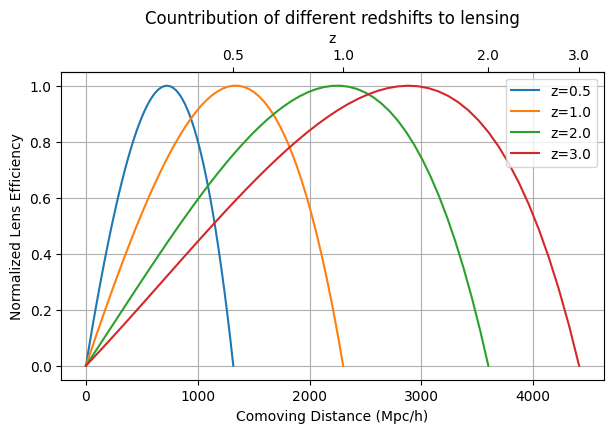

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import cosmology, constants as const, units as u

# Define the function
def lens_efficiency(chi, cosmo, zs):
    """Compute the weight function for weak lensing convergence."""
    chis = cosmo.comoving_distance(zs).value  # Mpc
    z = cosmology.z_at_value(cosmo.comoving_distance, chi * u.Mpc).value
    dchi = (1 - chi / chis).clip(0)
    return (1 + z) * chi * dchi  # 1/Mpc

def lensarray(cosmo, zs):
    # Create a range of chi values
    chi_values = np.linspace(0.1, cosmo.comoving_distance(zs).value, 50)
    lens_efficiencies = lens_efficiency(chi_values, cosmo, zs)
    lens_efficiencies = lens_efficiencies / np.max(lens_efficiencies)
    return chi_values*cosmo.h, lens_efficiencies

fig, ax = plt.subplots(figsize=(7, 4))

for zs in [0.5, 1.0, 2.0, 3.0]:
    chi_values, lens_efficiency_normalized = lensarray(cosmo, zs)
    ax.plot(chi_values, lens_efficiency_normalized, label=f'z={zs}')

ax.set_xlabel('Comoving Distance (Mpc/h)')
ax.set_ylabel('Normalized Lens Efficiency')
ax.set_title('Countribution of different redshifts to lensing')
ax.legend()

# Create a secondary x-axis for redshift
secax = ax.secondary_xaxis('top')
secax.set_xlabel('z')
redshift_ticks = [0.5, 1.0, 2.0, 3.0]
distance_ticks = [cosmo.comoving_distance(z).value * HUBBLE_CONSTANT for z in redshift_ticks]
secax.set_xticks(distance_ticks)
secax.set_xticklabels(redshift_ticks)

ax.grid(True)

# save the figure
plt.savefig(f'{save_dir}/lensefficiency.png', bbox_inches='tight')

# load catalog

In [21]:
def show_attrs(cath):
    boxsize, M_cdm, nc = cath.cat.attrs['BoxSize'][0], cath.cat.attrs['MassTable'][1], cath.cat.attrs['NC'][0]
    print(f"Boxsize: {boxsize}, M_cdm: {M_cdm}, nc: {nc}")
    ordering = cath.cat.attrs['healpix.scheme']
    print(f"Ordering: {ordering}")

cath_tiled = CatalogHandler(config_data.tileddir, config_data.source, config_data.dataset)
cath_bigbox = CatalogHandler(config_data.bigboxdir, config_data.source, config_data.dataset)

show_attrs(cath_tiled)
show_attrs(cath_bigbox)

/home/akira.tokiwa/.conda/envs/lssc/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)
2024-08-26 10:40:42,524 - INFO - Extra arguments to FileType: () {'dataset': 'HEALPIX/'}
2024-08-26 10:40:43,574 - INFO - Extra arguments to FileType: () {'dataset': 'HEALPIX/'}


Boxsize: 625.0, M_cdm: 1.9487254007799495, nc: 1024
Ordering: ['R' 'I' 'N' 'G' '']
Boxsize: 5000.0, M_cdm: 1.9487254007799495, nc: 8192
Ordering: ['R' 'I' 'N' 'G' '']


In [22]:
def get_indices(msheets, i, extra_index=100, start=None):
    # find where to start
    # start can be inherited from previous sheet
    if start is not None:
        start=start
        end=msheets.attrs['aemitIndex.offset'][i+2]
    else:
        start=msheets.attrs['aemitIndex.offset'][i+1]
        end=msheets.attrs['aemitIndex.offset'][i+2]
        if extra_index is not None:
            search_start_last = np.min([start + extra_index, end])
            aemit_start = msheets['Aemit'][start:search_start_last].compute()
            change_index_start = np.where(np.diff(aemit_start) == 0.01)[0]
            if len(change_index_start) != 0:
                logging.info(f"Aemit {np.round(aemit_start[change_index_start[0]], 2):.2f} start changed from {start} to {start + change_index_start[0]}")
                start = start + change_index_start[0]

    if start == end:
        return start, end
    
    logging.info(f"start: {start}, end: {end}")

    # take (start - extra_index) to (start + extra_index) to avoid bugs
    if extra_index is not None:
        search_end_first = np.max([end - extra_index, start])
        aemit_end = msheets['Aemit'][search_end_first:end].compute()
        change_index_end = np.where(np.round(np.diff(aemit_end), 2) == 0.01)[0]      
        if len(change_index_end) != 0:
            logging.info(f"Aemit {np.round(aemit_end[change_index_end[0]], 2):.2f} end changed from {end} to {end - change_index_end[0]}")
            end = end - change_index_end[0]
        return  start, end
    
    return start, end

In [23]:
prev_end = None
for i in range(20, 30):
    logging.info(f"Sheet {i}")
    start, end = get_indices(cath_tiled.cat, i, extra_index=50, start=prev_end)
    prev_end = end

2024-08-26 10:40:48,653 - INFO - Sheet 20


2024-08-26 10:41:15,802 - INFO - Sheet 21
2024-08-26 10:41:15,813 - INFO - Sheet 22
2024-08-26 10:41:15,824 - INFO - Sheet 23
2024-08-26 10:41:15,835 - INFO - Sheet 24
2024-08-26 10:41:15,846 - INFO - Sheet 25
2024-08-26 10:41:15,857 - INFO - Sheet 26
2024-08-26 10:41:15,879 - INFO - Sheet 27
2024-08-26 10:41:15,890 - INFO - Sheet 28
2024-08-26 10:41:15,901 - INFO - start: 33, end: 2415919106
2024-08-26 10:41:35,142 - INFO - Aemit 0.28 end changed from 2415919106 to 2415919090
2024-08-26 10:41:35,153 - INFO - Sheet 29
2024-08-26 10:41:35,164 - INFO - start: 2415919090, end: 5619061665
2024-08-26 10:41:53,534 - INFO - Aemit 0.29 end changed from 5619061665 to 5619061649


# load Mass sheet

In [27]:
def load_delta(path):
    sample = np.load(path)
    delta = sample['delta']
    chi1, chi2 = sample['chi1'][0], sample['chi2'][0]
    return delta, chi1, chi2

In [24]:


#mass_files_tiled = f"{config_data.tileddir}/mass_sheets/delta-sheet-50.npz"
mass_files_bigbox = f"{config_data.bigboxdir}/mass_sheets/delta-sheet-50.npz"
#delta_tiled, chi1_tiled, chi2_tiled = load_delta(mass_files_tiled)
delta_bigbox, chi1_bigbox, chi2_bigbox = load_delta(mass_files_bigbox)
#print(r"$\chi_1$ and $\chi_2$ for TILED" + f"{chi1_tiled:.2f} Mpc, {chi2_tiled:.2f} Mpc")
print(r"$\chi_1$ and $\chi_2$ for BIGBOX " + f"{chi1_bigbox:.2f} Mpc, {chi2_bigbox:.2f} Mpc")

$\chi_1$ and $\chi_2$ for BIGBOX 3396.01 Mpc, 3297.29 Mpc


In [25]:
mass_files_tiled_s100 = "/lustre/work/akira.tokiwa/Projects/LensingSSC/data/proc1024_nc1024_size625_nsteps60_s100_10tiled/mass_sheets/delta-sheet-50.npz"
mass_files_tiled_s201 = "/lustre/work/akira.tokiwa/Projects/LensingSSC/data/proc2048_nc1024_size625_nsteps60_s201_10tiled/mass_sheets/delta-sheet-50.npz"
mass_files_tiled_s301 = "/lustre/work/akira.tokiwa/Projects/LensingSSC/data/proc2048_nc1024_size625_nsteps60_s301_10tiled/mass_sheets/delta-sheet-50.npz"
mass_files_tiled_s401 = "/lustre/work/akira.tokiwa/Projects/LensingSSC/data/proc2048_nc1024_size625_nsteps60_s401_10tiled/mass_sheets/delta-sheet-50.npz"

delta_tiled_s100, chi1_tiled_s100, chi2_tiled_s100 = load_delta(mass_files_tiled_s100)
delta_tiled_s201, chi1_tiled_s201, chi2_tiled_s201 = load_delta(mass_files_tiled_s201)
delta_tiled_s301, chi1_tiled_s301, chi2_tiled_s301 = load_delta(mass_files_tiled_s301)
delta_tiled_s401, chi1_tiled_s401, chi2_tiled_s401 = load_delta(mass_files_tiled_s401)

print(r"$\chi_1$ and $\chi_2$ for s100:" + f"{chi1_tiled_s100:.2f} Mpc, {chi2_tiled_s100:.2f} Mpc")
print(r"$\chi_1$ and $\chi_2$ for s201:" + f"{chi1_tiled_s201:.2f} Mpc, {chi2_tiled_s201:.2f} Mpc")
print(r"$\chi_1$ and $\chi_2$ for s301:" + f"{chi1_tiled_s301:.2f} Mpc, {chi2_tiled_s301:.2f} Mpc")
print(r"$\chi_1$ and $\chi_2$ for s401:" + f"{chi1_tiled_s401:.2f} Mpc, {chi2_tiled_s401:.2f} Mpc")

$\chi_1$ and $\chi_2$ for s100:3396.01 Mpc, 3297.29 Mpc
$\chi_1$ and $\chi_2$ for s201:3396.01 Mpc, 3297.29 Mpc
$\chi_1$ and $\chi_2$ for s301:3396.01 Mpc, 3297.29 Mpc
$\chi_1$ and $\chi_2$ for s401:3396.01 Mpc, 3297.29 Mpc


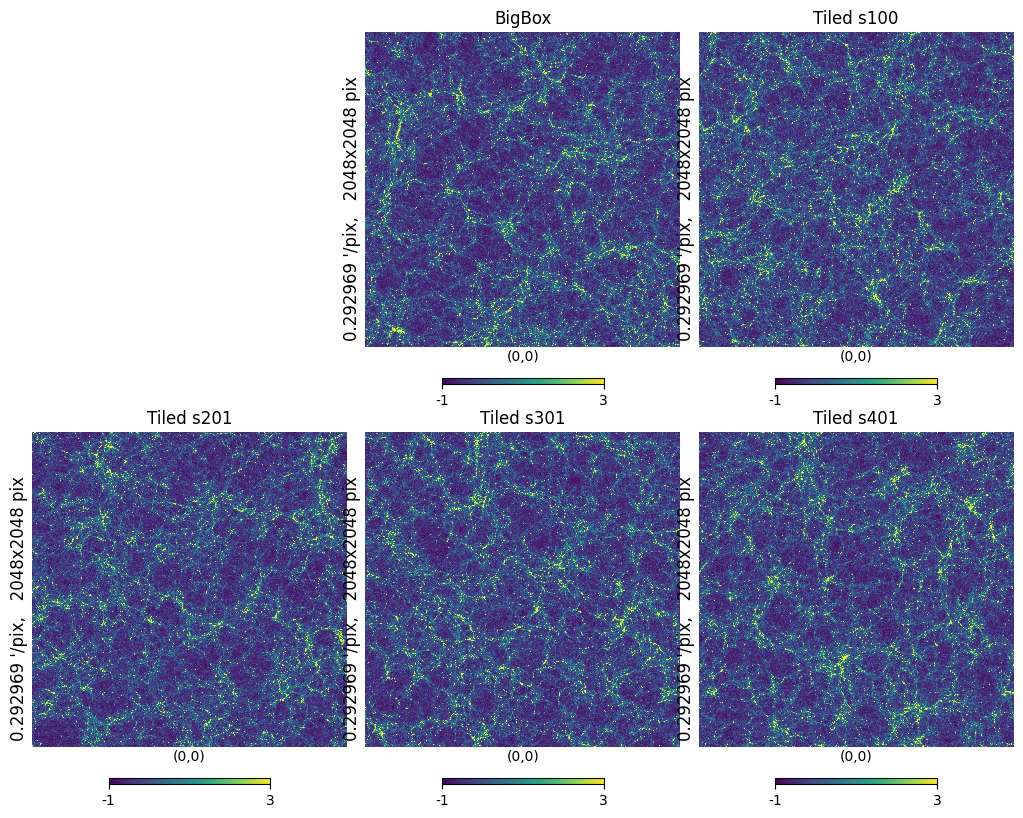

In [26]:
fig = plt.figure(figsize=(10, 8))
#hp.gnomview(delta_tiled, rot=[0, 0], reso=reso, xsize=xsize, title="Tiled", sub=(2, 3, 1), min=-1, max=3, fig=fig)
hp.gnomview(delta_bigbox, rot=[0, 0], reso=reso, xsize=xsize, title="BigBox", sub=(2, 3, 2), min=-1, max=3, fig=fig, nest=True)
hp.gnomview(delta_tiled_s100, rot=[0, 0], reso=reso, xsize=xsize, title="Tiled s100", sub=(2, 3, 3), min=-1, max=3, fig=fig, nest=True)
hp.gnomview(delta_tiled_s201, rot=[0, 0], reso=reso, xsize=xsize, title="Tiled s201", sub=(2, 3, 4), min=-1, max=3, fig=fig, nest=True)
hp.gnomview(delta_tiled_s301, rot=[0, 0], reso=reso, xsize=xsize, title="Tiled s301", sub=(2, 3, 5), min=-1, max=3, fig=fig, nest=True)
hp.gnomview(delta_tiled_s401, rot=[0, 0], reso=reso, xsize=xsize, title="Tiled s401", sub=(2, 3, 6), min=-1, max=3, fig=fig, nest=True)
plt.show()

# load data

In [19]:
def load_data2snr(path):
    sample = hp.read_map(path)
    #sigma = np.std(sample)
    #snr = sample / sigma
    return sample

vmin, vmax = -0.024, 0.024

In [20]:
fnames_tiled = os.path.join("/lustre/work/akira.tokiwa/Projects/LensingSSC/data/rfof_proc4096_nc1024_size625_nsteps60lin_ldr0_rcvtrue_fstnone_pnf2_lnf2_s100_dhf1.0000_tiled0.20_fll_elllim_10000_npix_8192_rfofkdt_8_LCDM_10tiled", "kappa", f"kappa_zs1.0.fits")
fnames_bigbox = os.path.join("/lustre/work/akira.tokiwa/Projects/LensingSSC/data/rfof_proc262144_nc8192_size5000_nsteps60lin_ldr0_rcvtrue_fstnone_pnf2_lnf2_s100_dhf1.0000_tiled0.20_fll_elllim_10000_npix_8192_rfofkdt_8", "kappa", f"kappa_zs1.0.fits")

snr_tiled = load_data2snr(fnames_tiled)
snr_bigbox = load_data2snr(fnames_bigbox)

2024-08-21 06:50:01,206 - INFO - NSIDE = 8192
2024-08-21 06:50:01,207 - INFO - ORDERING = RING in fits file
2024-08-21 06:50:01,207 - INFO - INDXSCHM = IMPLICIT
2024-08-21 06:50:12,496 - INFO - NSIDE = 8192
2024-08-21 06:50:12,497 - INFO - ORDERING = RING in fits file
2024-08-21 06:50:12,498 - INFO - INDXSCHM = IMPLICIT


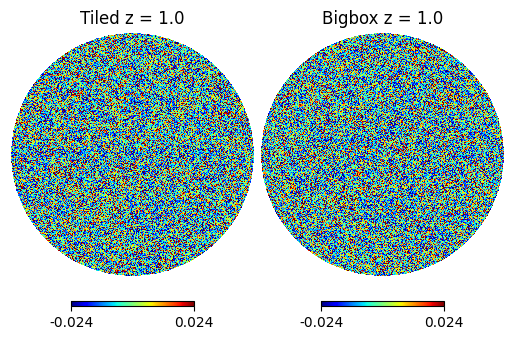

In [21]:
fig = plt.figure(figsize=(5, 5))
hp.orthview(snr_tiled, fig=1, title='Tiled z = 1.0', sub=(1, 2, 1), nest=True, cmap="jet", min=vmin, max=vmax, half_sky=True)
hp.orthview(snr_bigbox, fig=1, title='Bigbox z = 1.0', sub=(1, 2, 2), nest=True, cmap="jet", min=vmin, max=vmax, half_sky=True)

In [22]:
kappa_file_tiled_s100 = os.path.join("/lustre/work/akira.tokiwa/Projects/LensingSSC/data/proc1024_nc1024_size625_nsteps60_s100_10tiled", "kappa", "kappa_zs1.0_s100.fits")
kappa_file_tiled_s201 = os.path.join("/lustre/work/akira.tokiwa/Projects/LensingSSC/data/proc2048_nc1024_size625_nsteps60_s201_10tiled", "kappa", "kappa_zs1.0_s201.fits")
kappa_file_tiled_s301 = os.path.join("/lustre/work/akira.tokiwa/Projects/LensingSSC/data/proc2048_nc1024_size625_nsteps60_s301_10tiled", "kappa", "kappa_zs1.0_s301.fits")
kappa_file_tiled_s401 = os.path.join("/lustre/work/akira.tokiwa/Projects/LensingSSC/data/proc2048_nc1024_size625_nsteps60_s401_10tiled", "kappa", "kappa_zs1.0_s401.fits")

snr_tiled_s100 = load_data2snr(kappa_file_tiled_s100)
snr_tiled_s201 = load_data2snr(kappa_file_tiled_s201)
snr_tiled_s301 = load_data2snr(kappa_file_tiled_s301)
snr_tiled_s401 = load_data2snr(kappa_file_tiled_s401)

2024-08-21 06:50:24,638 - INFO - NSIDE = 8192
2024-08-21 06:50:24,639 - INFO - ORDERING = RING in fits file
2024-08-21 06:50:24,639 - INFO - INDXSCHM = IMPLICIT
2024-08-21 06:50:34,882 - INFO - NSIDE = 8192
2024-08-21 06:50:34,883 - INFO - ORDERING = RING in fits file
2024-08-21 06:50:34,884 - INFO - INDXSCHM = IMPLICIT
2024-08-21 06:50:46,197 - INFO - NSIDE = 8192
2024-08-21 06:50:46,198 - INFO - ORDERING = RING in fits file
2024-08-21 06:50:46,199 - INFO - INDXSCHM = IMPLICIT
2024-08-21 06:50:56,474 - INFO - NSIDE = 8192
2024-08-21 06:50:56,475 - INFO - ORDERING = RING in fits file
2024-08-21 06:50:56,475 - INFO - INDXSCHM = IMPLICIT


# Patch Sky

In [23]:
snr_patch_tiled = hp.gnomview(snr_tiled, rot=[0, 0], reso=reso, xsize=xsize, return_projected_map=True, no_plot=True, nest=True)
snr_patch_bigbox = hp.gnomview(snr_bigbox, rot=[0, 0], reso=reso, xsize=xsize, return_projected_map=True, no_plot=True, nest=True)

snr_patch_tiled_s100 = hp.gnomview(snr_tiled_s100, rot=[0, 0], reso=reso, xsize=xsize, return_projected_map=True, no_plot=True, nest=True)
snr_patch_tiled_s201 = hp.gnomview(snr_tiled_s201, rot=[0, 0], reso=reso, xsize=xsize, return_projected_map=True, no_plot=True, nest=True)
snr_patch_tiled_s301 = hp.gnomview(snr_tiled_s301, rot=[0, 0], reso=reso, xsize=xsize, return_projected_map=True, no_plot=True, nest=True)
snr_patch_tiled_s401 = hp.gnomview(snr_tiled_s401, rot=[0, 0], reso=reso, xsize=xsize, return_projected_map=True, no_plot=True, nest=True)

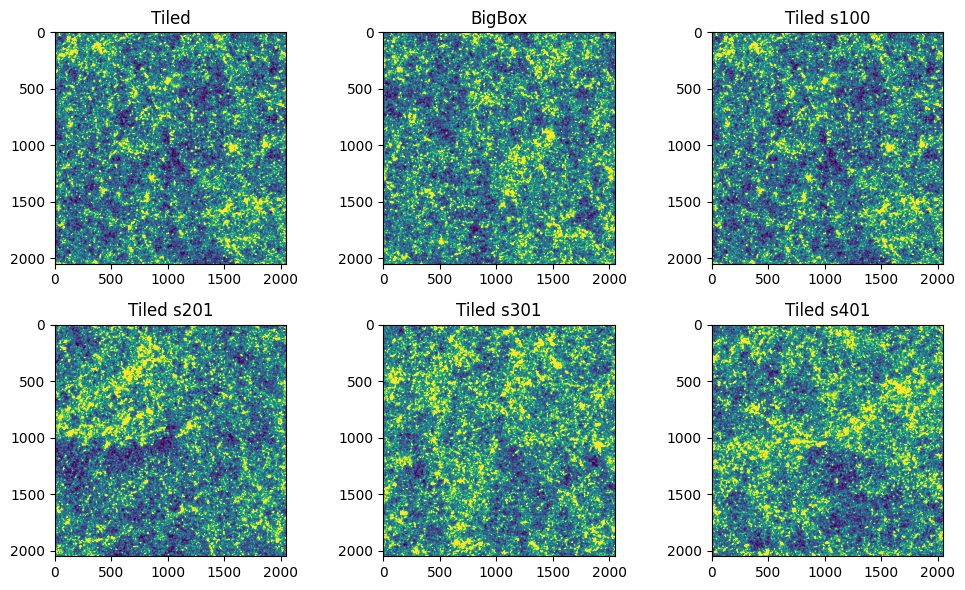

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
titles = ["Tiled", "BigBox", "Tiled s100", "Tiled s201", "Tiled s301", "Tiled s401"]
images = [snr_patch_tiled, snr_patch_bigbox, snr_patch_tiled_s100, snr_patch_tiled_s201, snr_patch_tiled_s301, snr_patch_tiled_s401]

for ax, title, img in zip(axes.flatten(), titles, images):
    ax.imshow(img, vmin=vmin, vmax=vmax)
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [25]:
conv_tiled = ConvergenceMap(snr_patch_tiled, angle=patch_size*u.deg)
conv_bigbox = ConvergenceMap(snr_patch_bigbox, angle=patch_size*u.deg)

conv_tiled_s100 = ConvergenceMap(snr_patch_tiled_s100, angle=patch_size*u.deg)
conv_tiled_s201 = ConvergenceMap(snr_patch_tiled_s201, angle=patch_size*u.deg)
conv_tiled_s301 = ConvergenceMap(snr_patch_tiled_s301, angle=patch_size*u.deg)
conv_tiled_s401 = ConvergenceMap(snr_patch_tiled_s401, angle=patch_size*u.deg)

In [26]:
class ShapeNoiseGenerator():
    def __init__(self, xsize, reso, ngal):
        self.xsize = xsize
        self.reso = reso
        self.ngal = ngal

    def generate(self, seed=np.random.randint(0, 1000)):
        np.random.seed(seed)
        sigma = 0.3 / (reso * np.sqrt(self.ngal))
        noise_map = np.random.normal(loc=0, scale=sigma, size=(self.xsize, self.xsize))
        return noise_map
    
def addNoise_smooth(patch_pixels, noise_map, patch_size=patch_size, scale_angle=2):
    convergence_map = ConvergenceMap(patch_pixels+noise_map, angle=patch_size * u.deg)
    convergence_map.smooth(scale_angle * u.arcmin, inplace=True)
    return convergence_map

In [27]:
noise_generator = ShapeNoiseGenerator(xsize, reso, ngal=30)

In [28]:
conv_noisy_smooth_tiled = addNoise_smooth(conv_tiled.data.data, noise_generator.generate(), patch_size=patch_size, scale_angle=2)
conv_noisy_smooth_bigbox = addNoise_smooth(conv_bigbox.data.data, noise_generator.generate(), patch_size=patch_size, scale_angle=2)

conv_noisy_smooth_tiled_s100 = addNoise_smooth(conv_tiled_s100.data.data, noise_generator.generate(), patch_size=patch_size, scale_angle=2)
conv_noisy_smooth_tiled_s201 = addNoise_smooth(conv_tiled_s201.data.data, noise_generator.generate(), patch_size=patch_size, scale_angle=2)
conv_noisy_smooth_tiled_s301 = addNoise_smooth(conv_tiled_s301.data.data, noise_generator.generate(), patch_size=patch_size, scale_angle=2)
conv_noisy_smooth_tiled_s401 = addNoise_smooth(conv_tiled_s401.data.data, noise_generator.generate(), patch_size=patch_size, scale_angle=2)

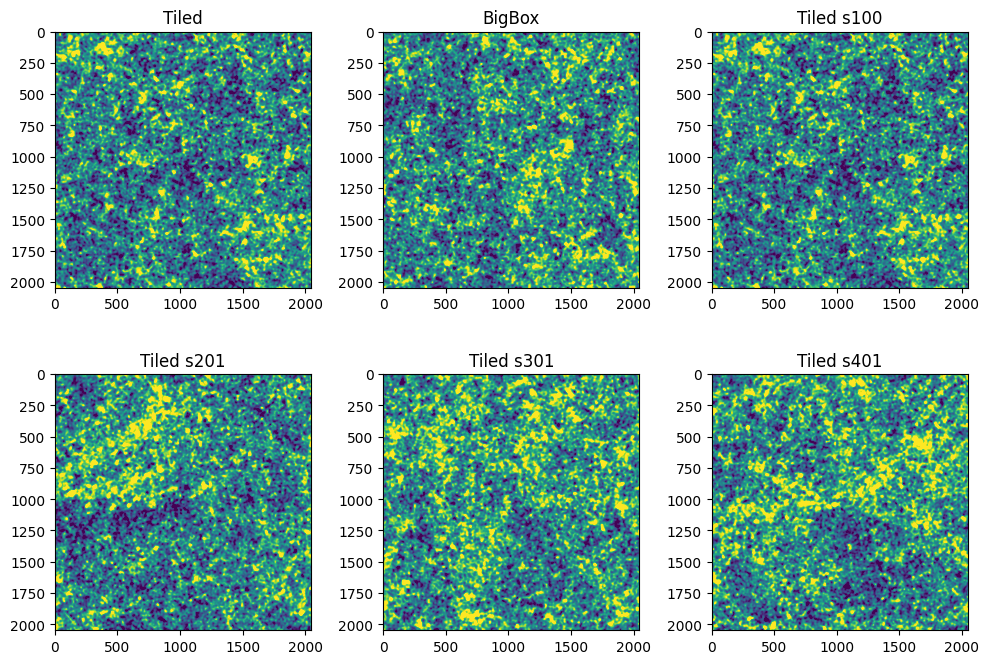

In [29]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
titles = ["Tiled", "BigBox", "Tiled s100", "Tiled s201", "Tiled s301", "Tiled s401"]
images = [
    conv_noisy_smooth_tiled.data.data,
    conv_noisy_smooth_bigbox.data.data,
    conv_noisy_smooth_tiled_s100.data.data,
    conv_noisy_smooth_tiled_s201.data.data,
    conv_noisy_smooth_tiled_s301.data.data,
    conv_noisy_smooth_tiled_s401.data.data
]

for ax, title, img in zip(axes.flatten(), titles, images):
    ax.imshow(img, vmin=vmin, vmax=vmax)
    ax.set_title(title)

plt.tight_layout()
plt.show()

# power Spectrum

In [277]:
hf = np.load("/lustre/work/akira.tokiwa/Projects/LensingSSC/results/halofit/kappa_zs1.0_Clkk_ell_0_3000.npz")
ell_hf, cl_hf = hf['ell'][lmin-1:], hf['clkk'][lmin-1:]

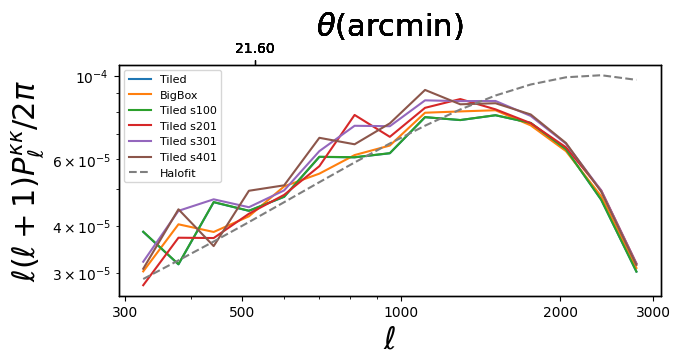

In [264]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))

conv_noisy_smooth_tiled.plotPowerSpectrum(l_edges, fig=fig, ax=ax,label="Tiled", color="tab:blue")
conv_noisy_smooth_bigbox.plotPowerSpectrum(l_edges, fig=fig, ax=ax,label="BigBox", color="tab:orange")
conv_noisy_smooth_tiled_s100.plotPowerSpectrum(l_edges, fig=fig, ax=ax,label="Tiled s100", color="tab:green")
conv_noisy_smooth_tiled_s201.plotPowerSpectrum(l_edges, fig=fig, ax=ax,label="Tiled s201", color="tab:red")
conv_noisy_smooth_tiled_s301.plotPowerSpectrum(l_edges, fig=fig, ax=ax,label="Tiled s301", color="tab:purple")
conv_noisy_smooth_tiled_s401.plotPowerSpectrum(l_edges, fig=fig, ax=ax,label="Tiled s401", color="tab:brown")

ax.plot(ell, ell * (ell+1) * cl_hf / (2*np.pi), label="Halofit", color="tab:gray", linestyle="--")

ax.set_xticks([300, 500, 1000, 2000, 3000])
ax.set_xticklabels([300, 500, 1000, 2000, 3000])

ax.legend(fontsize=8)
plt.show()

In [265]:
ell, cl_tiled = conv_noisy_smooth_tiled.powerSpectrum(l_edges)
ell, cl_bigbox = conv_noisy_smooth_bigbox.powerSpectrum(l_edges)

ell, cl_tiled_s100 = conv_noisy_smooth_tiled_s100.powerSpectrum(l_edges)
ell, cl_tiled_s201 = conv_noisy_smooth_tiled_s201.powerSpectrum(l_edges)
ell, cl_tiled_s301 = conv_noisy_smooth_tiled_s301.powerSpectrum(l_edges)
ell, cl_tiled_s401 = conv_noisy_smooth_tiled_s401.powerSpectrum(l_edges)

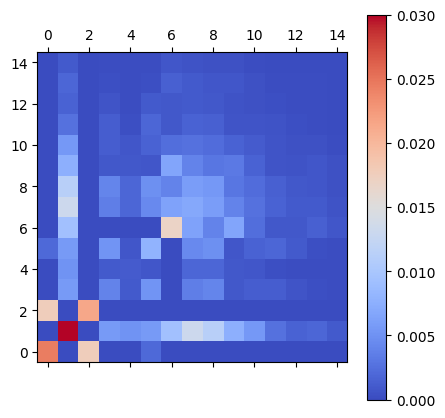

In [268]:
# stack the power spectra and compute the covariance matrix
cl = np.vstack([cl_tiled, cl_bigbox, cl_tiled_s100, cl_tiled_s201, cl_tiled_s301, cl_tiled_s401])
corr = np.corrcoef(cl, rowvar=False)
cov = np.cov(cl, rowvar=False)

# plot the covariance matrix
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cax = ax.matshow(cov/np.outer(cl_hf, cl_hf), cmap='coolwarm', vmin=0, vmax=0.03)
fig.colorbar(cax)
ax.invert_yaxis()
plt.show()

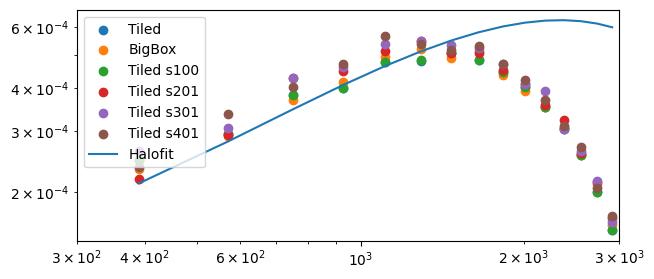

In [234]:
fig = plt.figure(figsize=(7, 3))
plt.scatter(ell, ell * (ell+1) * cl_tiled, label="Tiled")
plt.scatter(ell, ell * (ell+1) * cl_bigbox, label="BigBox")
plt.scatter(ell, ell * (ell+1) * cl_tiled_s100, label="Tiled s100")
plt.scatter(ell, ell * (ell+1) * cl_tiled_s201, label="Tiled s201")
plt.scatter(ell, ell * (ell+1) * cl_tiled_s301, label="Tiled s301")
plt.scatter(ell, ell * (ell+1) * cl_tiled_s401, label="Tiled s401")
plt.plot(ell, ell * (ell+1) * cl_hf, label="Halofit")
plt.xscale("log")
plt.yscale("log")
plt.xlim(lmin, lmax)
#plt.ylim(1e-4, 1e-3)
plt.legend()
plt.show()

# Peaks

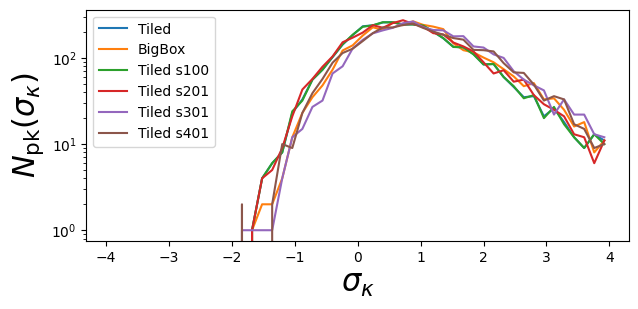

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))

conv_noisy_smooth_tiled.peakHistogram(bins, norm=True, fig=fig, ax=ax, label="Tiled")
conv_noisy_smooth_bigbox.peakHistogram(bins, norm=True, fig=fig, ax=ax, label="BigBox")
conv_noisy_smooth_tiled_s100.peakHistogram(bins, norm=True, fig=fig, ax=ax, label="Tiled s100")
conv_noisy_smooth_tiled_s201.peakHistogram(bins, norm=True, fig=fig, ax=ax, label="Tiled s201")
conv_noisy_smooth_tiled_s301.peakHistogram(bins, norm=True, fig=fig, ax=ax, label="Tiled s301")
conv_noisy_smooth_tiled_s401.peakHistogram(bins, norm=True, fig=fig, ax=ax, label="Tiled s401")

ax.legend()
plt.show()

In [56]:
def exclude_edges(heights, positions, patch_size_deg, xsize, return_index=True):
    tmp_positions = positions.value * xsize / patch_size_deg
    mask = (tmp_positions[:, 0] > 0) & (tmp_positions[:, 0] < xsize-1) & (tmp_positions[:, 1] > 0) & (tmp_positions[:, 1] < xsize-1)
    if return_index:
        return heights[mask], tmp_positions[mask].astype(int)
    else:
        return heights[mask], positions[mask]
    
def get_peaks(conv, bins, patch_size, xsize):
    heights, positions = conv.locatePeaks(bins, norm=True)
    heights, positions = exclude_edges(heights, positions, patch_size, xsize)
    return np.histogram(heights, bins=bins)[0]

In [57]:
peak_tiled = get_peaks(conv_noisy_smooth_tiled, bins , patch_size, xsize)
peak_bigbox = get_peaks(conv_noisy_smooth_bigbox, bins, patch_size, xsize)

peak_tiled_s100 = get_peaks(conv_noisy_smooth_tiled_s100, bins, patch_size, xsize)
peak_tiled_s201 = get_peaks(conv_noisy_smooth_tiled_s201, bins, patch_size, xsize)
peak_tiled_s301 = get_peaks(conv_noisy_smooth_tiled_s301, bins, patch_size, xsize)
peak_tiled_s401 = get_peaks(conv_noisy_smooth_tiled_s401, bins, patch_size, xsize)

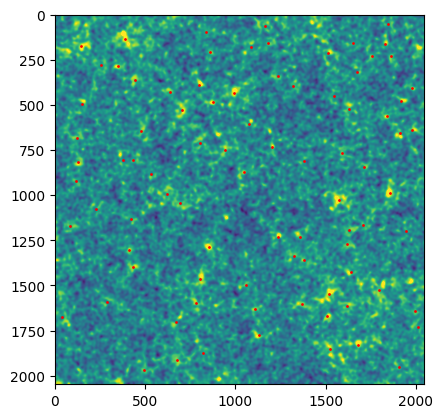

In [58]:
heights, positions = conv_noisy_smooth_tiled_s100.smooth(10*u.arcmin).locatePeaks(np.linspace(0, 3, 2))
heights, positions = exclude_edges(heights, positions, patch_size, xsize)

plt.imshow(conv_noisy_smooth_tiled_s100.data, vmin=vmin*2, vmax=vmax*2)
plt.scatter(positions[:, 0], positions[:, 1], c="r", s=1)
plt.show()


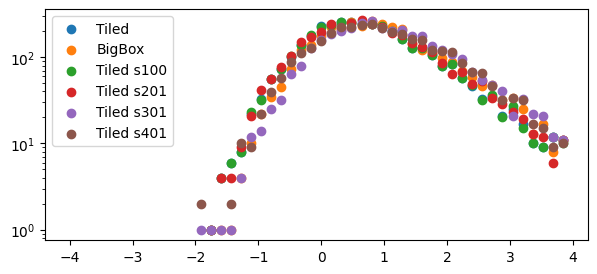

In [59]:
fig = plt.figure(figsize=(7, 3))
plt.scatter(bins[:-1], peak_tiled, label="Tiled")
plt.scatter(bins[:-1], peak_bigbox, label="BigBox")
plt.scatter(bins[:-1], peak_tiled_s100, label="Tiled s100")
plt.scatter(bins[:-1], peak_tiled_s201, label="Tiled s201")
plt.scatter(bins[:-1], peak_tiled_s301, label="Tiled s301")
plt.scatter(bins[:-1], peak_tiled_s401, label="Tiled s401")
plt.legend()
plt.yscale("log")
plt.show()

## PDF

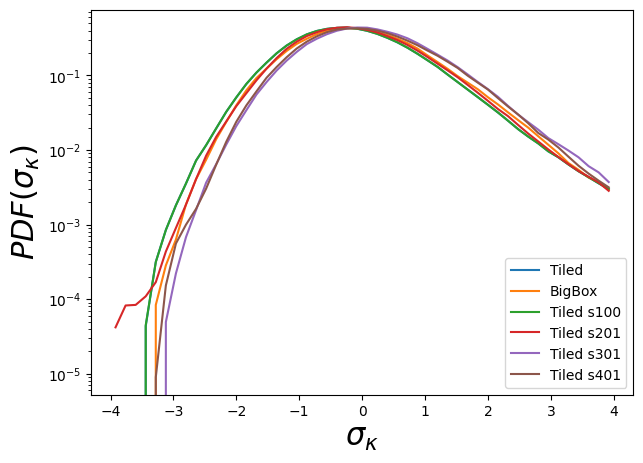

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

conv_noisy_smooth_tiled.plotPDF(bins, norm=True,fig=fig, ax=ax,label="Tiled", color="tab:blue")
conv_noisy_smooth_bigbox.plotPDF(bins, norm=True,fig=fig, ax=ax,label="BigBox", color="tab:orange")
conv_noisy_smooth_tiled_s100.plotPDF(bins, norm=True,fig=fig, ax=ax,label="Tiled s100", color="tab:green")
conv_noisy_smooth_tiled_s201.plotPDF(bins, norm=True,fig=fig, ax=ax,label="Tiled s201", color="tab:red")
conv_noisy_smooth_tiled_s301.plotPDF(bins, norm=True,fig=fig, ax=ax,label="Tiled s301", color="tab:purple")
conv_noisy_smooth_tiled_s401.plotPDF(bins, norm=True,fig=fig, ax=ax,label="Tiled s401", color="tab:brown")

ax.set_yscale("log")
ax.legend()
plt.show()

In [71]:
nu_tiled, pdf_tiled = conv_noisy_smooth_tiled.pdf(bins, norm=True)
nu_bigbox, pdf_bigbox = conv_noisy_smooth_bigbox.pdf(bins, norm=True)

nu_tiled_s100, pdf_tiled_s100 = conv_noisy_smooth_tiled_s100.pdf(bins, norm=True)
nu_tiled_s201, pdf_tiled_s201 = conv_noisy_smooth_tiled_s201.pdf(bins, norm=True)
nu_tiled_s301, pdf_tiled_s301 = conv_noisy_smooth_tiled_s301.pdf(bins, norm=True)
nu_tiled_s401, pdf_tiled_s401 = conv_noisy_smooth_tiled_s401.pdf(bins, norm=True)

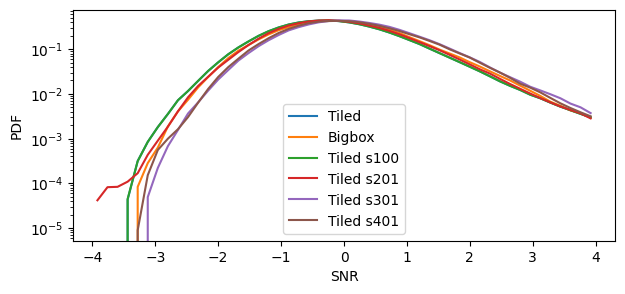

In [72]:
fig = plt.figure(figsize=(7, 3))
plt.plot(nu_tiled, pdf_tiled, label='Tiled')
plt.plot(nu_bigbox, pdf_bigbox, label='Bigbox')
plt.plot(nu_tiled_s100, pdf_tiled_s100, label='Tiled s100')
plt.plot(nu_tiled_s201, pdf_tiled_s201, label='Tiled s201')
plt.plot(nu_tiled_s301, pdf_tiled_s301, label='Tiled s301')
plt.plot(nu_tiled_s401, pdf_tiled_s401, label='Tiled s401')
plt.xlabel('SNR')
plt.ylabel('PDF')
plt.yscale('log')
plt.legend()

## bispectrum

In [63]:
ell, bseq_tiled = conv_noisy_smooth_tiled.bispectrum(l_edges, configuration='equilateral')
ell, bseq_bigbox = conv_noisy_smooth_bigbox.bispectrum(l_edges, configuration='equilateral')

ell, bseq_tiled_s100 = conv_noisy_smooth_tiled_s100.bispectrum(l_edges, configuration='equilateral')
ell, bseq_tiled_s201 = conv_noisy_smooth_tiled_s201.bispectrum(l_edges, configuration='equilateral')
ell, bseq_tiled_s301 = conv_noisy_smooth_tiled_s301.bispectrum(l_edges, configuration='equilateral')
ell, bseq_tiled_s401 = conv_noisy_smooth_tiled_s401.bispectrum(l_edges, configuration='equilateral')

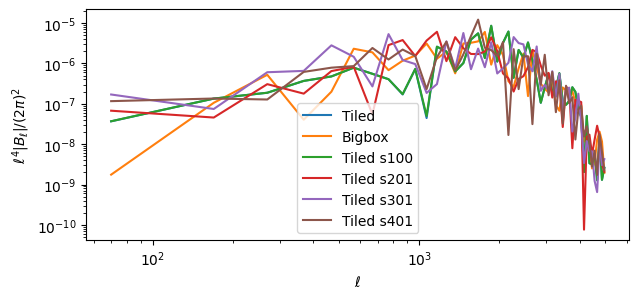

In [64]:
fig = plt.figure(figsize=(7, 3))
plt.plot(ell, np.abs(bseq_tiled) * ell**4 / (2*np.pi)**2, label='Tiled')
plt.plot(ell, np.abs(bseq_bigbox) * ell**4 / (2*np.pi)**2, label='Bigbox')
plt.plot(ell, np.abs(bseq_tiled_s100) * ell**4 / (2*np.pi)**2, label='Tiled s100')
plt.plot(ell, np.abs(bseq_tiled_s201) * ell**4 / (2*np.pi)**2, label='Tiled s201')
plt.plot(ell, np.abs(bseq_tiled_s301) * ell**4 / (2*np.pi)**2, label='Tiled s301')
plt.plot(ell, np.abs(bseq_tiled_s401) * ell**4 / (2*np.pi)**2, label='Tiled s401')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^4|B_{\ell}|/(2\pi)^2$')
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()

In [65]:
ell, bssq_tiled = conv_noisy_smooth_tiled.bispectrum(l_edges, configuration='folded', ratio=0.1)
ell, bssq_bigbox = conv_noisy_smooth_bigbox.bispectrum(l_edges, configuration='folded', ratio=0.1)

ell, bssq_tiled_s100 = conv_noisy_smooth_tiled_s100.bispectrum(l_edges, configuration='folded', ratio=0.1)
ell, bssq_tiled_s201 = conv_noisy_smooth_tiled_s201.bispectrum(l_edges, configuration='folded', ratio=0.1)
ell, bssq_tiled_s301 = conv_noisy_smooth_tiled_s301.bispectrum(l_edges, configuration='folded', ratio=0.1)
ell, bssq_tiled_s401 = conv_noisy_smooth_tiled_s401.bispectrum(l_edges, configuration='folded', ratio=0.1)

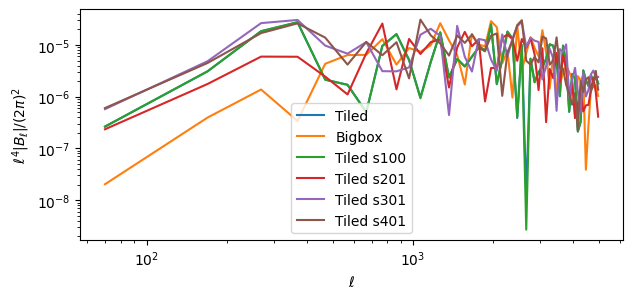

In [66]:
fig = plt.figure(figsize=(7, 3))
plt.plot(ell, np.abs(bssq_tiled) * ell**4 / (2*np.pi)**2, label='Tiled')
plt.plot(ell, np.abs(bssq_bigbox) * ell**4 / (2*np.pi)**2, label='Bigbox')
plt.plot(ell, np.abs(bssq_tiled_s100) * ell**4 / (2*np.pi)**2, label='Tiled s100')
plt.plot(ell, np.abs(bssq_tiled_s201) * ell**4 / (2*np.pi)**2, label='Tiled s201')
plt.plot(ell, np.abs(bssq_tiled_s301) * ell**4 / (2*np.pi)**2, label='Tiled s301')
plt.plot(ell, np.abs(bssq_tiled_s401) * ell**4 / (2*np.pi)**2, label='Tiled s401')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^4|B_{\ell}|/(2\pi)^2$')
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()

# Full data matrix

In [12]:
hf = np.load("/lustre/work/akira.tokiwa/Projects/LensingSSC/results/halofit/kappa_zs1.0_Clkk_ell_0_3000.npz")
ell_hf, cl_hf = hf['ell'][lmin-1:], hf['clkk'][lmin-1:]

In [13]:
ell_idx = np.digitize(ell_hf, l_edges, right=True)
cl_hf = np.bincount(ell_idx, weights=cl_hf)
ell_bincount = np.bincount(ell_idx)
cl_hf = (cl_hf/ell_bincount)[1:]

/var/tmp/pbs.276109.idark/ipykernel_77228/1226910294.py:4: RuntimeWarning: invalid value encountered in true_divide
  cl_hf = (cl_hf/ell_bincount)[1:]


In [6]:
def normalize_peak(peak):
    return (peak.T/np.sum(peak, axis=1)).T

def dimensionless_cl(cl, ell):
    return ell * (ell+1) * cl / (2*np.pi)

def dimiensionless_bispectrum(bispec, ell):
    return bispec * ell**4 / (2*np.pi)**2

In [7]:
datadir="/lustre/work/akira.tokiwa/Projects/LensingSSC/data"
datas = glob(f"{datadir}/*/flat/*zs1.0*.npy")
datas.sort()
datas.pop(-1)

'/lustre/work/akira.tokiwa/Projects/LensingSSC/data/rfof_proc4096_nc1024_size625_nsteps60lin_ldr0_rcvtrue_fstnone_pnf2_lnf2_s100_dhf1.0000_tiled0.20_fll_elllim_10000_npix_8192_rfofkdt_8_LCDM_10tiled/flat/analysis_eqsqclpdpm_zs1.0_sl2_ngal30.npy'

In [8]:
data_bigbox = np.load(datas[-2])
eq_bigbox, sq_bigbox, clkk_bigbox, pdf_bigbox, peak_bigbox, minima_bigbox = np.split(data_bigbox, 6, axis=1)
eq_bigbox = dimiensionless_bispectrum(eq_bigbox, ell)
sq_bigbox = dimiensionless_bispectrum(sq_bigbox, ell)
clkk_bigbox = dimensionless_cl(clkk_bigbox, ell)
peak_bigbox = normalize_peak(peak_bigbox)
minima_bigbox = normalize_peak(minima_bigbox)
data_bigbox = np.hstack([eq_bigbox, sq_bigbox, clkk_bigbox, pdf_bigbox, peak_bigbox, minima_bigbox])

cov_ell_bigbox = np.cov(data_bigbox[:, :nbin*3], rowvar=False)
cov_nu_bigbox = np.cov(data_bigbox[:, nbin*3:], rowvar=False)

diag_bigbox = np.diag(np.cov(data_bigbox, rowvar=False))
corr_bigbox = np.corrcoef(data_bigbox, rowvar=False)
#mean_bigbox = np.mean(data_bigbox, axis=0)
std_bigbox = np.std(data_bigbox, axis=0)
#eq_bigbox, sq_bigbox, clkk_bigbox, pdf_bigbox, peak_bigbox, minima_bigbox = np.split(mean_bigbox, 6)
eq_std_bigbox, sq_std_bigbox, clkk_std_bigbox, pdf_std_bigbox, peak_std_bigbox, minima_std_bigbox = np.split(std_bigbox, 6)

datas.pop(-1)

'/lustre/work/akira.tokiwa/Projects/LensingSSC/data/rfof_proc262144_nc8192_size5000_nsteps60lin_ldr0_rcvtrue_fstnone_pnf2_lnf2_s100_dhf1.0000_tiled0.20_fll_elllim_10000_npix_8192_rfofkdt_8/flat/analysis_eqsqclpdpm_zs1.0_sl2_ngal30.npy'

In [9]:
data_tiled = np.vstack([np.load(data) for data in datas])
eq_tiled, sq_tiled, clkk_tiled, pdf_tiled, peak_tiled, minima_tiled = np.split(data_tiled, 6, axis=1)
eq_tiled = dimiensionless_bispectrum(eq_tiled, ell)
sq_tiled = dimiensionless_bispectrum(sq_tiled, ell)
clkk_tiled = dimensionless_cl(clkk_tiled, ell)
peak_tiled = normalize_peak(peak_tiled)
minima_tiled = normalize_peak(minima_tiled)
data_tiled = np.hstack([eq_tiled, sq_tiled, clkk_tiled, pdf_tiled, peak_tiled, minima_tiled])

diags_tiled = [np.diag(np.cov(data, rowvar=False)) for data in np.split(data_tiled, len(datas), axis=0)]
diags_std_tiled = np.std(diags_tiled, axis=0)

cov_ell_tiled = np.cov(data_tiled[:, :nbin*3], rowvar=False)
cov_nu_tiled = np.cov(data_tiled[:, nbin*3:], rowvar=False)

diag_tiled = np.diag(np.cov(data_tiled, rowvar=False))
corr_tiled = np.corrcoef(data_tiled, rowvar=False)
#mean_tiled = np.mean(data_tiled, axis=0)
std_tiled = np.std(data_tiled, axis=0)
#eq_tiled, sq_tiled, clkk_tiled, pdf_tiled, peak_tiled, minima_tiled = np.split(mean_tiled, 6)
eq_std_tiled, sq_std_tiled, clkk_std_tiled, pdf_std_tiled, peak_std_tiled, minima_std_tiled = np.split(std_tiled, 6)

In [10]:
data_tiled_s100 = np.load(f"{datadir}/proc1024_nc1024_size625_nsteps60_s100_10tiled/flat/analysis_eqsqclpdpm_zs1.0_s100_sl2_ngal30.npy")
eq_tiled_s100, sq_tiled_s100, clkk_tiled_s100, pdf_tiled_s100, peak_tiled_s100, minima_tiled_s100 = np.split(data_tiled_s100, 6, axis=1)
eq_tiled_s100 = dimiensionless_bispectrum(eq_tiled_s100, ell)
sq_tiled_s100 = dimiensionless_bispectrum(sq_tiled_s100, ell)
clkk_tiled_s100 = dimensionless_cl(clkk_tiled_s100, ell)
peak_tiled_s100 = normalize_peak(peak_tiled_s100)
minima_tiled_s100 = normalize_peak(minima_tiled_s100)
data_tiled_s100 = np.hstack([eq_tiled_s100, sq_tiled_s100, clkk_tiled_s100, pdf_tiled_s100, peak_tiled_s100, minima_tiled_s100])

diag_tiled_s100 = np.diag(np.cov(data_tiled_s100, rowvar=False))
corr_tiled_s100 = np.corrcoef(data_tiled_s100, rowvar=False)
#mean_tiled_s100 = np.mean(data_tiled_s100, axis=0)
#eq_tiled_s100, sq_tiled_s100, clkk_tiled_s100, pdf_tiled_s100, peak_tiled_s100, minima_tiled_s100 = np.split(mean_tiled_s100, 6)

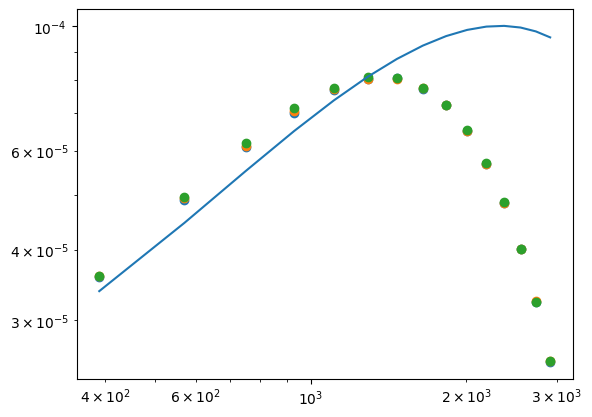

In [15]:
plt.scatter(ell, np.mean(clkk_tiled_s100, axis=0))
plt.scatter(ell, np.mean(clkk_tiled, axis=0))
plt.scatter(ell, np.mean(clkk_bigbox, axis=0))
plt.plot(ell,  dimensionless_cl(cl_hf, ell), label="Halofit")
plt.xscale("log")
plt.yscale("log")
plt.show()

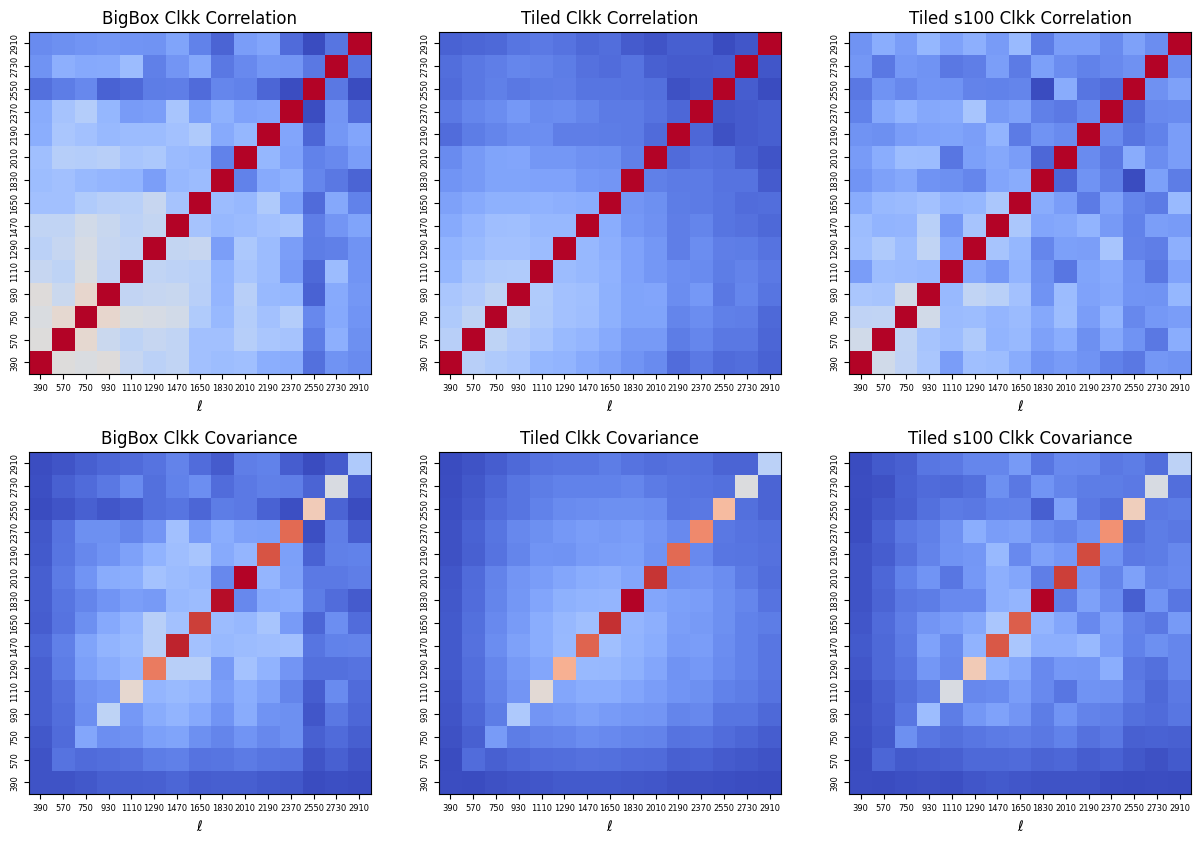

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0, 0].imshow(np.corrcoef(clkk_bigbox, rowvar=False), cmap='coolwarm')
ax[0, 0].set_title("BigBox Clkk Correlation")
ax[0, 1].imshow(np.corrcoef(clkk_tiled, rowvar=False), cmap='coolwarm')
ax[0, 1].set_title("Tiled Clkk Correlation")
ax[0, 2].imshow(np.corrcoef(clkk_tiled_s100, rowvar=False), cmap='coolwarm')
ax[0, 2].set_title("Tiled s100 Clkk Correlation")

ax[1, 0].imshow(np.cov(clkk_bigbox, rowvar=False)/np.outer(cl_hf, cl_hf), cmap='coolwarm')
ax[1, 0].set_title("BigBox Clkk Covariance")
ax[1, 1].imshow(np.cov(clkk_tiled, rowvar=False)/np.outer(cl_hf, cl_hf), cmap='coolwarm')
ax[1, 1].set_title("Tiled Clkk Covariance")
ax[1, 2].imshow(np.cov(clkk_tiled_s100, rowvar=False)/np.outer(cl_hf, cl_hf), cmap='coolwarm')
ax[1, 2].set_title("Tiled s100 Clkk Covariance")

tick_positions = [i for i in range(nbin)]
for axes in ax.flatten():
    axes.set_xlabel(r"$\ell$")
    axes.set_xticks(tick_positions, ell.astype(np.int32), fontsize=6)
    axes.set_yticks(tick_positions, ell.astype(np.int32), fontsize=6, rotation=90, va='center')
    axes.invert_yaxis()

plt.show()

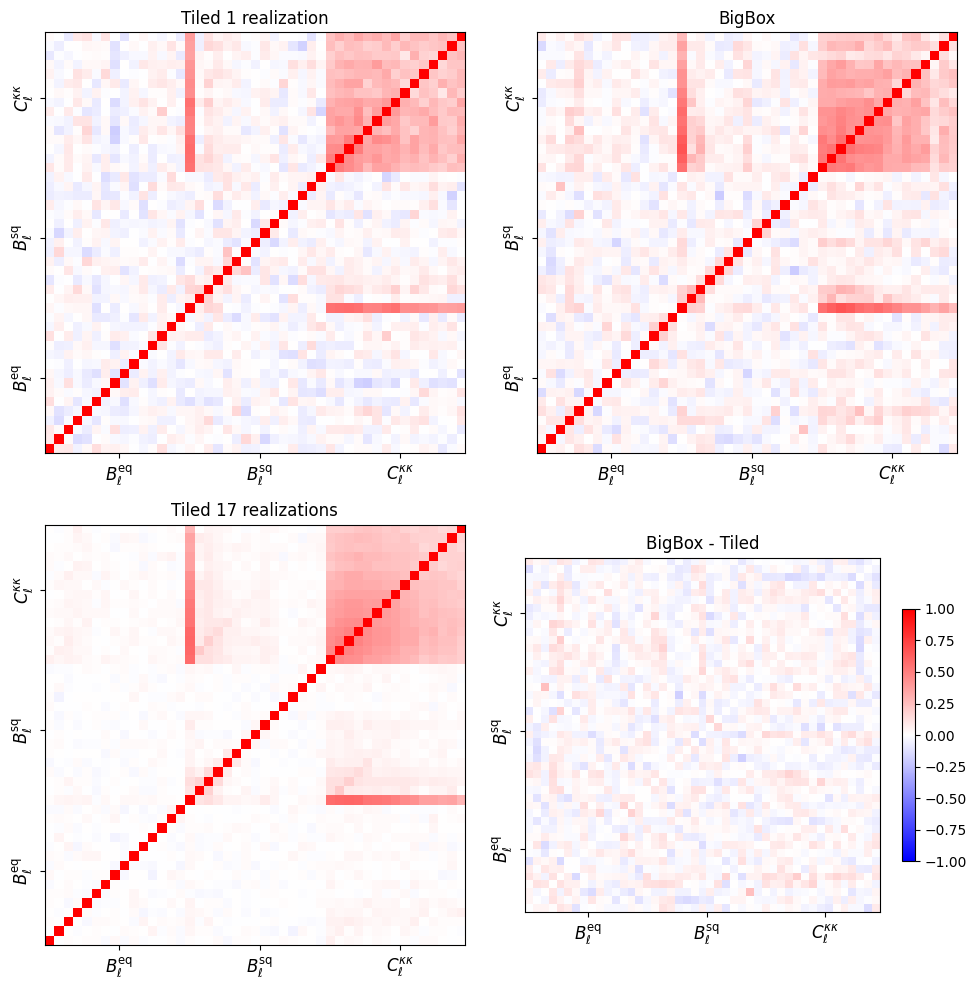

In [19]:
labels = [r'$B_{\ell}^\mathrm{eq}$', 
          r'$B_{\ell}^\mathrm{sq}$', 
          r'$C^{\kappa\kappa}_{\ell}$']

tick_positions = [nbin/2 + nbin * i for i in range(len(labels))]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(corr_tiled_s100[:nbin *3, :nbin *3], cmap='bwr', vmin=-1, vmax=1)
ax[0, 0].set_title("Tiled 1 realization")

ax[1, 0].imshow(corr_tiled[:nbin *3, :nbin *3], cmap='bwr', vmin=-1, vmax=1)
ax[1, 0].set_title(f"Tiled {len(datas)} realizations")

ax[0, 1].imshow(corr_bigbox[:nbin *3, :nbin *3], cmap='bwr', vmin=-1, vmax=1)
ax[0, 1].set_title("BigBox")

im = ax[1, 1].imshow(corr_bigbox[:nbin *3, :nbin *3] - corr_tiled[:nbin *3, :nbin *3], cmap='bwr', vmin=-1, vmax=1)
ax[1, 1].set_title("BigBox - Tiled")
fig.colorbar(im, ax=ax[1, 1], shrink=0.6)

for axes in ax.flatten():
    axes.set_xticks(tick_positions, labels, fontsize=12)
    axes.set_yticks(tick_positions, labels, fontsize=12, rotation=90, va='center')
    axes.invert_yaxis()

plt.tight_layout()
plt.show()

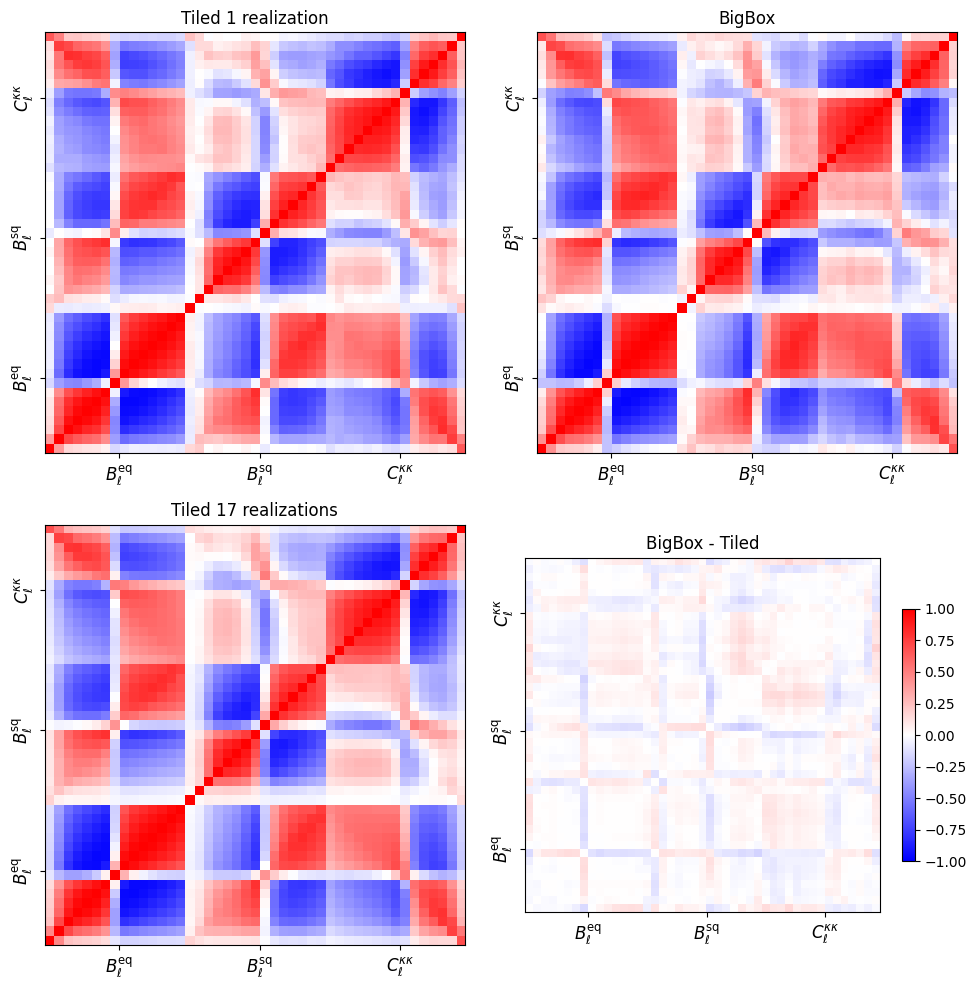

In [20]:
labels = [r'$B_{\ell}^\mathrm{eq}$', 
          r'$B_{\ell}^\mathrm{sq}$', 
          r'$C^{\kappa\kappa}_{\ell}$']

tick_positions = [nbin/2 + nbin * i for i in range(len(labels))]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(corr_tiled_s100[nbin *3:, nbin *3:], cmap='bwr', vmin=-1, vmax=1)
ax[0, 0].set_title("Tiled 1 realization")

ax[1, 0].imshow(corr_tiled[nbin *3:, nbin *3:], cmap='bwr', vmin=-1, vmax=1)
ax[1, 0].set_title(f"Tiled {len(datas)} realizations")

ax[0, 1].imshow(corr_bigbox[nbin *3:, nbin *3:], cmap='bwr', vmin=-1, vmax=1)
ax[0, 1].set_title("BigBox")

im = ax[1, 1].imshow(corr_bigbox[nbin *3:, nbin *3:] - corr_tiled[nbin *3:, nbin *3:], cmap='bwr', vmin=-1, vmax=1)
ax[1, 1].set_title("BigBox - Tiled")
fig.colorbar(im, ax=ax[1, 1], shrink=0.6)

for axes in ax.flatten():
    axes.set_xticks(tick_positions, labels, fontsize=12)
    axes.set_yticks(tick_positions, labels, fontsize=12, rotation=90, va='center')
    axes.invert_yaxis()

plt.tight_layout()
plt.show()

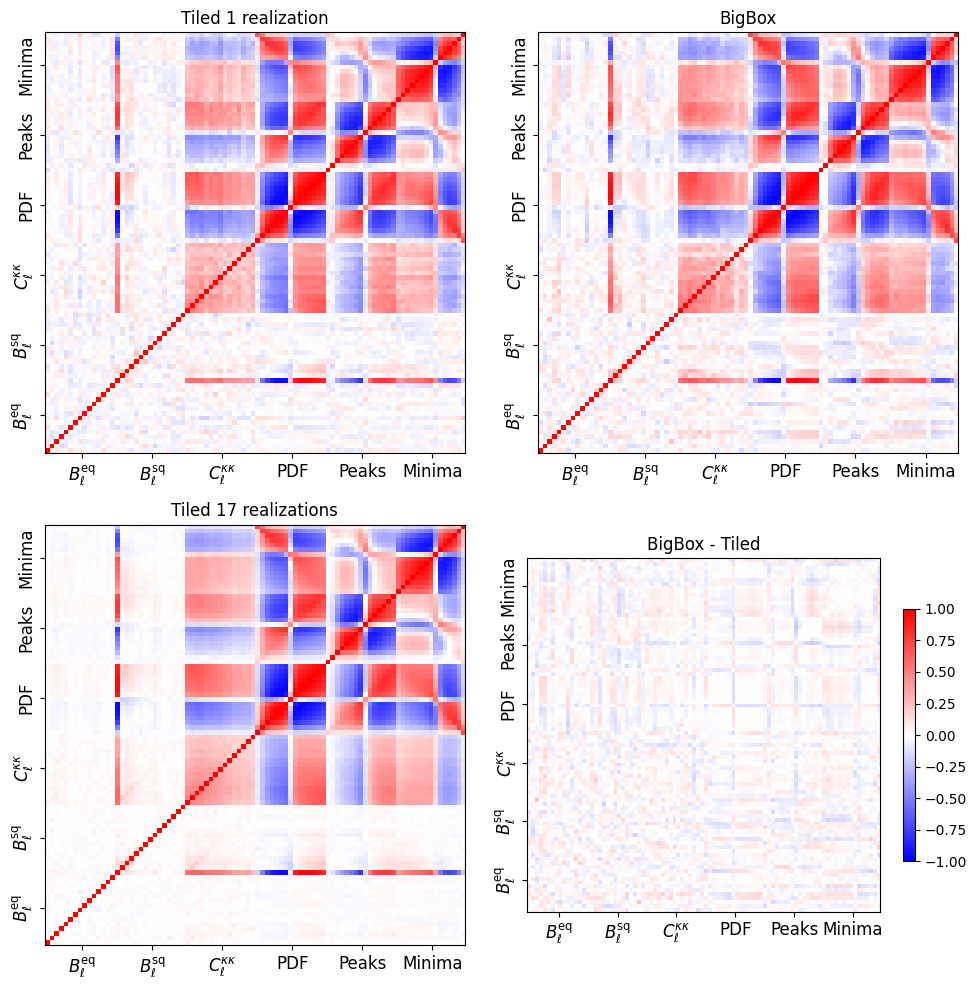

In [17]:
labels = [r'$B_{\ell}^\mathrm{eq}$', 
          r'$B_{\ell}^\mathrm{sq}$', 
          r'$C^{\kappa\kappa}_{\ell}$', 
          "PDF",
          "Peaks",
          "Minima"]

tick_positions = [nbin/2 + nbin * i for i in range(len(labels))]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(corr_tiled_s100, cmap='bwr', vmin=-1, vmax=1)
ax[0, 0].set_title("Tiled 1 realization")

ax[1, 0].imshow(corr_tiled, cmap='bwr', vmin=-1, vmax=1)
ax[1, 0].set_title(f"Tiled {len(datas)} realizations")

ax[0, 1].imshow(corr_bigbox, cmap='bwr', vmin=-1, vmax=1)
ax[0, 1].set_title("BigBox")

im = ax[1, 1].imshow(corr_bigbox - corr_tiled, cmap='bwr', vmin=-1, vmax=1)
ax[1, 1].set_title("BigBox - Tiled")
fig.colorbar(im, ax=ax[1, 1], shrink=0.6)

for axes in ax.flatten():
    axes.set_xticks(tick_positions, labels, fontsize=12)
    axes.set_yticks(tick_positions, labels, fontsize=12, rotation=90, va='center')
    axes.invert_yaxis()

plt.tight_layout()
plt.show()

In [187]:
hf = np.load("/lustre/work/akira.tokiwa/Projects/LensingSSC/results/halofit/kappa_zs1.0_Clkk_ell_0_3000.npz")
ell_hf, cl_hf = hf['ell'], hf['clkk']
dcl_hf = dimensionless_cl(cl_hf, ell_hf)

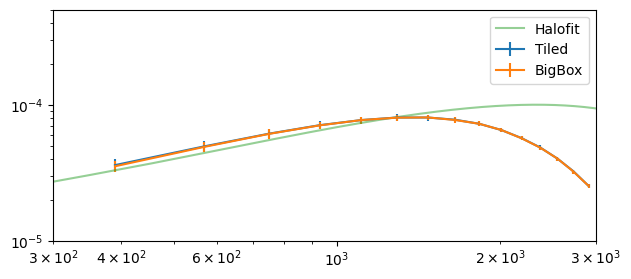

In [188]:
fig = plt.figure(figsize=(7, 3))
plt.errorbar(ell, clkk_tiled, yerr= clkk_std_tiled, label="Tiled")
plt.errorbar(ell, clkk_bigbox, yerr= clkk_std_bigbox, label="BigBox")
plt.plot(ell_hf, dcl_hf, label="Halofit", alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(300, 3000)
plt.ylim(1e-5, 5 * 1e-4)
plt.legend()
plt.show()

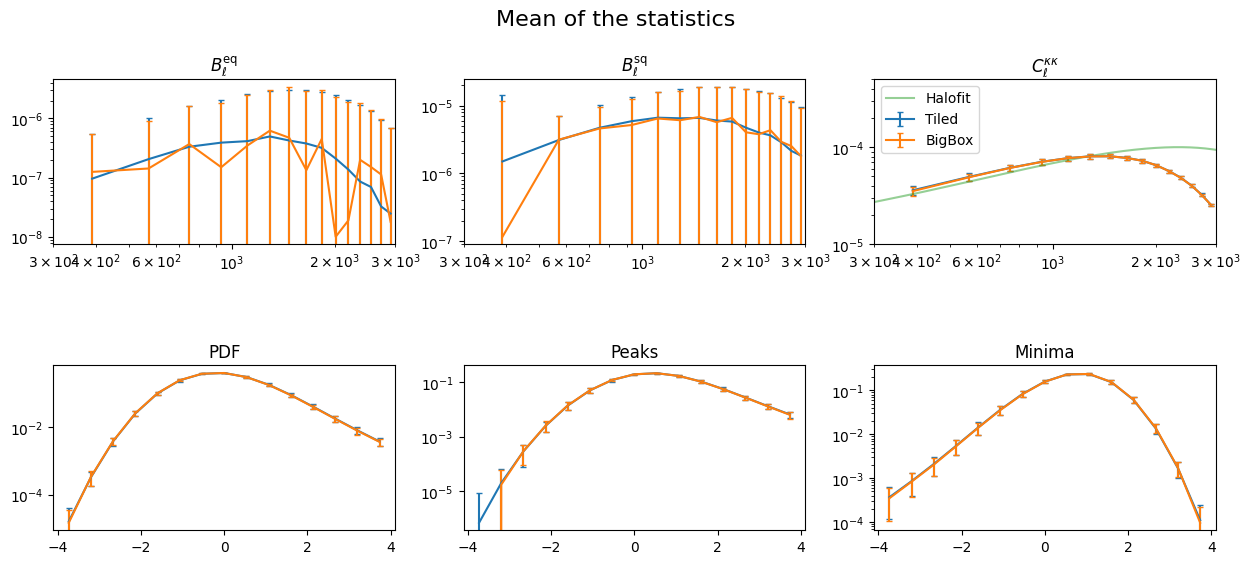

In [200]:
from matplotlib.gridspec import GridSpec

# Create the figure and GridSpec layout
fig = plt.figure(figsize=(15, 7))
gs = GridSpec(4, 3, height_ratios=[3, 1, 3, 1], hspace=0.3)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)] + [fig.add_subplot(gs[2, i]) for i in range(3)]

for i, label in enumerate(labels):
    ax = axes[i]
    if i < 3:
        ax.errorbar(ell, mean_tiled[i*15:i*15+15], yerr=std_tiled[i*15:i*15+15], label="Tiled", capsize=2)
        ax.errorbar(ell, mean_bigbox[i*15:i*15+15], yerr=std_bigbox[i*15:i*15+15], label="BigBox", capsize=2, c="tab:orange")
        if i == 2:
            ax.plot(ell_hf, dcl_hf, label="Halofit", alpha=0.5, c="tab:green")
            ax.set_ylim(1e-5, 5 * 1e-4)
            ax.legend()

        ax.set_title(label)
        ax.set_xlim(300, 3000)
        ax.set_yscale('log')
        ax.set_xscale('log')
    else:
        ax.errorbar(b, mean_tiled[i*15:i*15+15], yerr=std_tiled[i*15:i*15+15], label="Tiled", capsize=2)
        ax.errorbar(b, mean_bigbox[i*15:i*15+15], yerr=std_bigbox[i*15:i*15+15], label="BigBox", capsize=2, c="tab:orange")
        ax.set_title(label)
        ax.set_yscale('log')

# set the title of this figure
fig.suptitle("Mean of the statistics", fontsize=16)
plt.show()

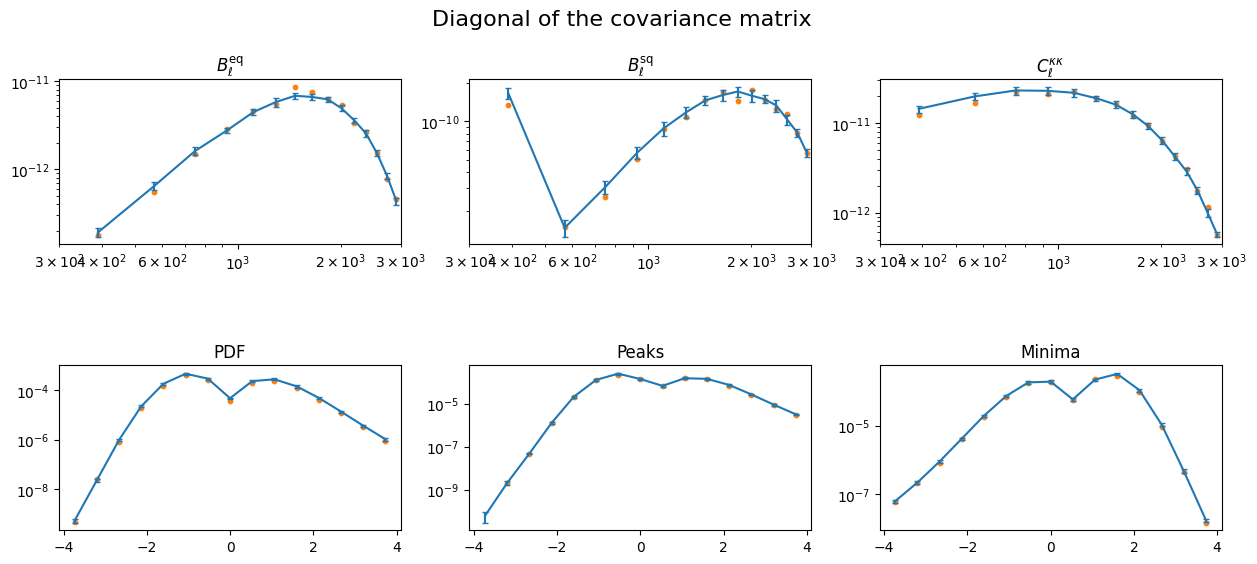

In [201]:
# Create the figure and GridSpec layout
fig = plt.figure(figsize=(15, 7))
gs = GridSpec(4, 3, height_ratios=[3, 1, 3, 1], hspace=0.3)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)] + [fig.add_subplot(gs[2, i]) for i in range(3)]

for i, label in enumerate(labels):
    ax = axes[i]
    if i < 3:
        ax.errorbar(ell, diag_tiled[i*15:i*15+15], yerr=diags_std_tiled[i*15:i*15+15], label="Tiled", capsize=2)
        ax.scatter(ell, diag_bigbox[i*15:i*15+15], label="BigBox", s=10, c='tab:orange')    

        ax.set_title(label)
        ax.set_xlim(300, 3000)
        ax.set_yscale('log')
        ax.set_xscale('log')
    else:
        ax.errorbar(b, diag_tiled[i*15:i*15+15], yerr=diags_std_tiled[i*15:i*15+15], label="Tiled", capsize=2)
        ax.scatter(b, diag_bigbox[i*15:i*15+15], label="BigBox", s=10, c='tab:orange')
        ax.set_title(label)
        ax.set_yscale('log')

# set the title of this figure
fig.suptitle("Diagonal of the covariance matrix", fontsize=16)
plt.show()